### Credit Card Fraud

---

Hadirnya kartu kredit sebagai sebuah variasi metode pembayaran telah membantu dan mempermudah kegiatan transaksi kita sehari-hari. Kelebihan bertransaksi dengan kartu kredit adalah kita dapat melakukan pembayaran tanpa menggunakan uang tunai dan juga dapat menunda pembayaran hingga tenggat waktu yang telah ditentukan. Kemudahan yang ditawarkan oleh penggunaan kartu kredit juga memicu munculnya penipuan atau fraud dimana biasanya terjadi penggunaan informasi kartu kredit oleh pengguna yang tidak berwenang untuk melakukan transaksi. Berdasarkan hal tersebut maka dibutuhkan penanganan untuk kasus fraud yang terjadi, penanganan yang direkomendasikan adalah dengan melihat data aktifitas transaksi nasabah untu kemudian ditentukan apakah transaksi tersebut fraud atau tidak. Data yang digunakan bersumber dari Kaggle dengan keterangan sebagai berikut :  



| Column | Info |
|---|---|
|distance_from_home|the distance from home where the transaction happened|
|distance_from_last_transaction|the distance from last transaction happened|
|ratio_to_median_purchase_price|Ratio of purchased price transaction to median purchase price|
|repeat_retailer|Is the transaction happened from same retailer|
|used_chip|Is the transaction through chip (credit card)|
|used_pin_number|Is the transaction happened by using PIN number|
|online_order|Is the transaction an online order|
|fraud|Is the transaction fraudulent|
  
  
Pendeteksian fraud dilakukan dengan membuat model machine learning yang dapat mempelajari pola pada dataset. Metode yang digunakan pada data ini adalah dengan membandingkan beberapa jenis model sekaligus untuk nantinya dipilih model mana yang menunjukkan hasil lebih baik.
  
---

Sumber data:
https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data

# 1. Loading Library

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import pickle 
import json
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr, chi2_contingency
from sklearn.model_selection import train_test_split

C:\Users\asus\AppData\Local\Temp\ipykernel_9076\1216400014.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Load data

In [2]:
'''Load data dari csv'''
df = pd.read_csv('card_transdata.csv', delimiter=',')

In [3]:
'''Memunculkan data dengan urutan 5 baris teratas'''
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [4]:
'''Menunjukkan informasi dasar dataset'''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [5]:
'''Mengecek apakah ada data yang null'''
df.isna().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

Tidak ada data yang null

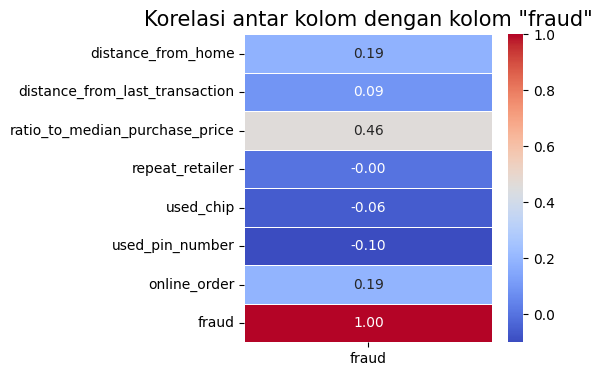

In [10]:
# Menghitung korelasi Spearman antara setiap kolom dengan kolom "fraud"
correlation_matrix_spearman = df.corr(method='pearson')

# Memvisualisasikan heatmap korelasi
plt.figure(figsize=(4, 4))
sns.heatmap(correlation_matrix_spearman[['fraud']], annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korelasi antar kolom dengan kolom "fraud"', fontsize=15)
plt.show()

Grafik diatas menunjukkan korelasi tiap kolom dengan kolom fraud. Kolom fraud adalah kolom target yang akan digunakan sebagai parameter apakah sebuah transaksi merupakan fraud.
  
Berdasarkan grafik didapati bahwa kolom dengan nilai korelasi terbesar adalah kolom ratio_to_median_purchase_price disusul dengan distance_from_home dan online_order.
  
Biasanya dalam feature engineering akan mengambil kolom-kolom tertentu dengan nilai korelasi terbesar saja untuk digunakan dalam model, namun karena dataset ini memiliki kolom yang terbatas maka seluruh kolom akan digunakan dalam model.

In [11]:
'''Memisahkan data menjadi data fitur (X) dan target (y)'''
y = df['fraud']
X = df.drop(columns=['fraud'])

# Pertama, pisahkan data menjadi data pelatihan dan sisa data
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.4, random_state=32)

# Selanjutnya, pisahkan sisa data menjadi data uji dan data validasi
X_test, X_val, y_test, y_val = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=32)

# Print ukuran setiap set data
print("Ukuran data pelatihan (train):", X_train.shape[0])
print("Ukuran data uji (test):", X_test.shape[0])
print("Ukuran data validasi (validation):", X_val.shape[0])


Ukuran data pelatihan (train): 600000
Ukuran data uji (test): 200000
Ukuran data validasi (validation): 200000


In [12]:
'''Menyimpan X_val ke dalam file CSV untuk nanti digunakan pada model'''

X_val.to_csv('validation_data.csv', index=False)

In [13]:
'''melakukan scaling'''
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled

array([[ 0.35741855,  0.0046768 , -0.2630643 , ...,  1.3612591 ,
        -0.33466507, -1.3646693 ],
       [-0.40208922, -0.21272206,  0.81354056, ...,  1.3612591 ,
        -0.33466507,  0.73277826],
       [-0.39704812, -0.22194059,  0.89679925, ...,  1.3612591 ,
        -0.33466507,  0.73277826],
       ...,
       [-0.03277965, -0.05439577,  0.08211491, ..., -0.734614  ,
        -0.33466507, -1.3646693 ],
       [-0.37232788, -0.14165489, -0.25948454, ..., -0.734614  ,
        -0.33466507, -1.3646693 ],
       [-0.38463982, -0.22997186, -0.18187669, ..., -0.734614  ,
        -0.33466507, -1.3646693 ]])

# 3. Modelling

### KNN

In [14]:
'''Membuat pipeline untuk KNN'''

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

print('Pipeline steps : ', knn_pipeline.steps)

Pipeline steps :  [('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]


### SVM

In [15]:
'''Definisikan pipeline untuk SVM'''

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

print('Pipeline steps : ', svm_pipeline.steps)

Pipeline steps :  [('scaler', StandardScaler()), ('svm', SVC())]


### Decision Tree

In [16]:
'''Definisikan pipeline untuk Decision Tree'''

dt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier())
])

print('Pipeline steps : ', dt_pipeline.steps)

Pipeline steps :  [('scaler', StandardScaler()), ('dt', DecisionTreeClassifier())]


### Random Forest

In [17]:
'''Definisikan pipeline untuk Random Forest'''

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])

print('Pipeline steps : ', rf_pipeline.steps)

Pipeline steps :  [('scaler', StandardScaler()), ('rf', RandomForestClassifier())]


### XGBoost

In [18]:
'''Definisikan pipeline untuk XGBoost'''

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier())
])
print('Pipeline steps : ', xgb_pipeline.steps)

Pipeline steps :  [('scaler', StandardScaler()), ('xgb', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...))]


## Pipeline

In [19]:
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

In [20]:
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC())])

In [21]:
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('dt', DecisionTreeClassifier())])

In [22]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

In [23]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

## Model Training

### KNN Predict & Evaluation

In [24]:
'''Predict Train-set and Test-set'''
y_pred_train_knn = knn_pipeline.predict(X_train)
y_pred_test_knn = knn_pipeline.predict(X_test)

# Print classification report
print('Classification Report KNN Train: ')
print(classification_report(y_train, y_pred_train_knn))
print('Classification Report KNN Test: ')
print(classification_report(y_test, y_pred_test_knn))

Classification Report KNN Train: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    547282
         1.0       1.00      0.99      1.00     52718

    accuracy                           1.00    600000
   macro avg       1.00      1.00      1.00    600000
weighted avg       1.00      1.00      1.00    600000

Classification Report KNN Test: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182691
         1.0       0.99      0.99      0.99     17309

    accuracy                           1.00    200000
   macro avg       1.00      0.99      1.00    200000
weighted avg       1.00      1.00      1.00    200000



### SVM Predict & Evaluation

In [25]:
'''SVM Predict & Evaluation# Predict Train-set and Test-set'''
y_pred_train_svm = svm_pipeline.predict(X_train)
y_pred_test_svm = svm_pipeline.predict(X_test)

# Print classification report
print('Classification Report SVM Train: ')
print(classification_report(y_train, y_pred_train_svm))
print('Classification Report SVM Test: ')
print(classification_report(y_test, y_pred_test_svm))

Classification Report SVM Train: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    547282
         1.0       0.99      0.98      0.99     52718

    accuracy                           1.00    600000
   macro avg       1.00      0.99      0.99    600000
weighted avg       1.00      1.00      1.00    600000

Classification Report SVM Test: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182691
         1.0       0.99      0.98      0.99     17309

    accuracy                           1.00    200000
   macro avg       1.00      0.99      0.99    200000
weighted avg       1.00      1.00      1.00    200000



### Decision Tree Prediction & Evaluation

In [26]:
'''Predict Train-set and Test-set'''
y_pred_train_dt = dt_pipeline.predict(X_train)
y_pred_test_dt = dt_pipeline.predict(X_test)

# Print classification report
print('Classification Report Decision Tree Train: ')
print(classification_report(y_train, y_pred_train_dt))
print('Classification Report Decision Tree Test: ')
print(classification_report(y_test, y_pred_test_dt))

Classification Report Decision Tree Train: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    547282
         1.0       1.00      1.00      1.00     52718

    accuracy                           1.00    600000
   macro avg       1.00      1.00      1.00    600000
weighted avg       1.00      1.00      1.00    600000

Classification Report Decision Tree Test: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182691
         1.0       1.00      1.00      1.00     17309

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



### Random Forest Prediction & Evaluation

In [27]:
'''Predict Train-set and Test-set'''
y_pred_train_rf = rf_pipeline.predict(X_train)
y_pred_test_rf = rf_pipeline.predict(X_test)

# Print classification report
print('Classification Report Random Forest Train: ')
print(classification_report(y_train, y_pred_train_rf))
print('Classification Report Random Forest Test: ')
print(classification_report(y_test, y_pred_test_rf))

Classification Report Random Forest Train: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    547282
         1.0       1.00      1.00      1.00     52718

    accuracy                           1.00    600000
   macro avg       1.00      1.00      1.00    600000
weighted avg       1.00      1.00      1.00    600000

Classification Report Random Forest Test: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182691
         1.0       1.00      1.00      1.00     17309

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



### XGBoost Prediction & Evaluation

In [28]:
'''Predict Train-set and Test-set'''
y_pred_train_xgb = xgb_pipeline.predict(X_train)
y_pred_test_xgb = xgb_pipeline.predict(X_test)

# Print classification report
print('Classification Report XGBoost Train: ')
print(classification_report(y_train, y_pred_train_xgb))
print('Classification Report XGBoost Test: ')
print(classification_report(y_test, y_pred_test_xgb))

Classification Report XGBoost Train: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    547282
         1.0       0.99      1.00      0.99     52718

    accuracy                           1.00    600000
   macro avg       1.00      1.00      1.00    600000
weighted avg       1.00      1.00      1.00    600000

Classification Report XGBoost Test: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182691
         1.0       0.99      0.99      0.99     17309

    accuracy                           1.00    200000
   macro avg       0.99      1.00      0.99    200000
weighted avg       1.00      1.00      1.00    200000



# 4. Cross Validation

Cross Validation yang dilakukan saat ini berfokus pada recall. Recall di sini mengukur kemampuan model untuk mendeteksi semua kemungkinan kasus positif (fraud) dari keseluruhan kasus yang sebenarnya. Dalam konteks deteksi fraud, sangat penting untuk meminimalkan jumlah kasus fraud yang terlewat (false negative), bahkan jika itu berarti akan meningkatkan jumlah false positive. Jadi, tujuan utama dari evaluasi ini adalah untuk memastikan bahwa model dapat mengidentifikasi sebanyak mungkin transaksi fraud, meskipun hal itu bisa mengakibatkan peningkatan dalam false positif.

## Cross Validation KNN

In [29]:
#Cross Validation KNN

knn_prc_train_cross_val = cross_val_score(knn_pipeline,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="recall")

print('KNN Recall Score - All - Cross Validation  : ', knn_prc_train_cross_val)
print('KNN Recall Score - Mean - Cross Validation : ', knn_prc_train_cross_val.mean())
print('KNN Recall Score - Std - Cross Validation  : ', knn_prc_train_cross_val.std())
print('KNN Recall Score - Range of Test-Set       : ', (knn_prc_train_cross_val.mean()-knn_prc_train_cross_val.std()) , '-', (knn_prc_train_cross_val.mean()+knn_prc_train_cross_val.std()))

KNN Recall Score - All - Cross Validation  :  [0.98708172 0.98787913 0.98725317]
KNN Recall Score - Mean - Cross Validation :  0.9874046753868798
KNN Recall Score - Std - Cross Validation  :  0.00034271587742310276
KNN Recall Score - Range of Test-Set       :  0.9870619595094567 - 0.9877473912643029


## Cross Validation SVM

In [30]:
#Cross Validation SVM

svm_prc_train_cross_val = cross_val_score(svm_pipeline,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="recall")

print('SVM Recall Score - All - Cross Validation  : ', svm_prc_train_cross_val)
print('SVM Recall Score - Mean - Cross Validation : ', svm_prc_train_cross_val.mean())
print('SVM Recall Score - Std - Cross Validation  : ', svm_prc_train_cross_val.std())
print('SVM Recall Score - Range of Test-Set       : ', (svm_prc_train_cross_val.mean()-svm_prc_train_cross_val.std()) , '-', (svm_prc_train_cross_val.mean()+svm_prc_train_cross_val.std()))

SVM Recall Score - All - Cross Validation  :  [0.98048031 0.98093666 0.97962784]
SVM Recall Score - Mean - Cross Validation :  0.9803482706483352
SVM Recall Score - Std - Cross Validation  :  0.0005424217983553735
SVM Recall Score - Range of Test-Set       :  0.9798058488499798 - 0.9808906924466906


## Cross Validation Decision Tree

In [31]:
#Cross Validation Decision Tree

dt_prc_train_cross_val = cross_val_score(dt_pipeline,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="recall")

print('Decision Tree Recall Score - All - Cross Validation  : ', dt_prc_train_cross_val)
print('Decision Tree Recall Score - Mean - Cross Validation : ', dt_prc_train_cross_val.mean())
print('Decision Tree Recall Score - Std - Cross Validation  : ', dt_prc_train_cross_val.std())
print('Decision Tree Recall Score - Range of Test-Set       : ', (dt_prc_train_cross_val.mean()-dt_prc_train_cross_val.std()) , '-', (dt_prc_train_cross_val.mean()+dt_prc_train_cross_val.std()))

Decision Tree Recall Score - All - Cross Validation  :  [0.99954473 0.99988619 0.99982928]
Decision Tree Recall Score - Mean - Cross Validation :  0.9997534009508954
Decision Tree Recall Score - Std - Cross Validation  :  0.00014937013006924434
Decision Tree Recall Score - Range of Test-Set       :  0.9996040308208262 - 0.9999027710809646


## Cross Validation Random Forest

In [32]:
#Cross Validation Random Forest

rf_prc_train_cross_val = cross_val_score(rf_pipeline,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="recall")

print('Random Forest Recall Score - All - Cross Validation  : ', rf_prc_train_cross_val)
print('Random Forest Recall Score - Mean - Cross Validation : ', rf_prc_train_cross_val.mean())
print('Random Forest Recall Score - Std - Cross Validation  : ', rf_prc_train_cross_val.std())
print('Random Forest Recall Score - Range of Test-Set       : ', (rf_prc_train_cross_val.mean()-rf_prc_train_cross_val.std()) , '-', (rf_prc_train_cross_val.mean()+rf_prc_train_cross_val.std()))

Random Forest Recall Score - All - Cross Validation  :  [0.99960164 0.99988619 0.99982928]
Random Forest Recall Score - Mean - Cross Validation :  0.9997723705237006
Random Forest Recall Score - Std - Cross Validation  :  0.0001229403804179655
Random Forest Recall Score - Range of Test-Set       :  0.9996494301432827 - 0.9998953109041185


## Cross Validation XGBoost

In [33]:
#Cross Validation XGBoost

xgb_prc_train_cross_val = cross_val_score(xgb_pipeline,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="recall")

print('XGBoost Recall Score - All - Cross Validation  : ', xgb_prc_train_cross_val)
print('XGBoost Recall Score - Mean - Cross Validation : ', xgb_prc_train_cross_val.mean())
print('XGBoost Recall Score - Std - Cross Validation  : ', xgb_prc_train_cross_val.std())
print('XGBoost Recall Score - Range of Test-Set       : ', (xgb_prc_train_cross_val.mean()-xgb_prc_train_cross_val.std()) , '-', (xgb_prc_train_cross_val.mean()+xgb_prc_train_cross_val.std()))

XGBoost Recall Score - All - Cross Validation  :  [0.9915206  0.99163489 0.99123656]
XGBoost Recall Score - Mean - Cross Validation :  0.9914640171589172
XGBoost Recall Score - Std - Cross Validation  :  0.00016747070755520813
XGBoost Recall Score - Range of Test-Set       :  0.991296546451362 - 0.9916314878664724


## Kesimpulan

Berdasarkan hasil evaluasi model, terlihat bahwa semua model yang diuji, termasuk KNN, SVM, Decision Tree, Random Forest, dan XGBoost, menunjukkan kinerja yang sangat baik dalam mendeteksi kasus fraud pada transaksi kredit. Hal ini terlihat dari nilai precision, recall, dan f1-score yang sangat tinggi, mendekati 1.00 untuk kedua kelas (0 dan 1), baik pada data pelatihan maupun data uji. Hasil ini menunjukkan bahwa model-model tersebut mampu dengan sangat baik membedakan antara transaksi yang sah dan fraud.

Dalam konteks cross validation, hasilnya juga menunjukkan kemampuan model-model tersebut dalam mendeteksi kasus fraud secara konsisten pada berbagai kondisi data pelatihan. Rata-rata recall score dari cross validation berkisar antara 0.98 hingga 0.99, menunjukkan bahwa model-model ini mampu secara konsisten mengidentifikasi sebagian besar kasus fraud, bahkan ketika diuji pada dataset yang berbeda-beda.

Dari gabungan evaluasi model dan cross validation, dapat disimpulkan bahwa semua model yang diuji memiliki performa yang sangat baik dalam mendeteksi fraud pada transaksi kredit. Namun, ada sedikit variasi dalam performa antara model-model tersebut, di mana model Decision Tree, Random Forest, dan XGBoost menunjukkan hasil yang sedikit lebih baik dalam hal recall. Oleh karena itu, untuk keperluan deteksi fraud pada transaksi kredit, model-model tersebut dapat dianggap sebagai pilihan yang sangat baik, dengan model Decision Tree, Random Forest, dan XGBoost mungkin menjadi pilihan yang lebih unggul.

# Model Saving

In [34]:
'''Menyimpan model yang sudah dibuat, dimana model yang disimpan adalah Decision Tree.
Model tersebut dipilih karena memiliki nilai recall yang tinggi. Model akan digunakan untuk file 
inference yang dibuat pada file terpisah'''

with open('model_decision_tree.pkl', 'wb') as file_model:
  pickle.dump(dt_pipeline, file_model)